# Relevance Functions

In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    get_info_experiment
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data


In [4]:
# Re-import necessary libraries after kernel reset
import numpy as np
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

def compute_tukey_boxplot_bounds(y):
    """
    Compute boxplot bounds using Tukey's original rule (no skewness correction).
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1

    lower = q1 + 0.1*iqr
    upper = q3 
    median = np.median(y)

    return lower, median, upper

def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

def create_relevance_function_tukey(y):
    """
    Create a PCHIP-based relevance function φ(y) using Tukey boxplot bounds.
    """
    lower, median, upper = compute_adjusted_boxplot_bounds(y)
    
    # Extend with actual min/max to smooth edges
    # x = np.array([min(y), lower, median, upper, max(y)])
    x = np.array([lower, median, upper, max(y)])
    print("Lower, median, upper, max:")
    print(x)
    # if x[1] < x[0]:
    #     x[1] = (x[0]+ x[2])/2
    relevance = np.array([0, 0, 1.0, 1.0])

    # Ensure strictly increasing x by removing duplicate values
    x_unique, idx = np.unique(x, return_index=True)
    relevance_unique = relevance[idx]
    pchip = PchipInterpolator(x_unique, relevance_unique, extrapolate=True)
    return pchip

def compute_sera(y_true, y_pred, relevance_fn, step=0.01):
    """
    Compute SERA metric given true values, predictions, and a relevance function φ(y).
    """
    t_values = np.arange(0, 1 + step, step)
    ser_t = []

    for t in t_values:
        indices = [i for i, y in enumerate(y_true) if relevance_fn(y) >= t]
        if len(indices) == 0:
            ser_t.append(0.0)
            continue
        squared_errors = [(y_pred[i] - y_true[i]) ** 2 for i in indices]
        ser_t.append(np.sum(squared_errors))

    sera_score = np.trapz(ser_t, t_values)
    return sera_score, t_values, ser_t

In [5]:
# TensorFlow-compatible SERA metric wrapper
def compute_sera_tensor(y_true, y_pred, relevance_fn, step=0.01):
    """
    TensorFlow-compatible version of SERA for use as a metric in Keras.
    Assumes y_true and y_pred are 1D tensors.
    `relevance_fn` must be a NumPy function; we'll wrap it using tf.numpy_function.
    """
    def sera_np(y_true_np, y_pred_np):
        t_values = np.arange(0, 1 + step, step)
        ser_t = []
        rel_true = relevance_fn(y_true_np)

        for t in t_values:
            indices = np.where(rel_true >= t)[0]
            if len(indices) == 0:
                ser_t.append(0.0)
                continue
            errors = (y_pred_np[indices] - y_true_np[indices]) ** 2
            ser_t.append(np.mean(errors))

        sera_score = np.trapz(ser_t, t_values)
        return np.float32(sera_score)

    return tf.numpy_function(sera_np, [y_true, y_pred], tf.float32)

In [6]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")

In [7]:
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])

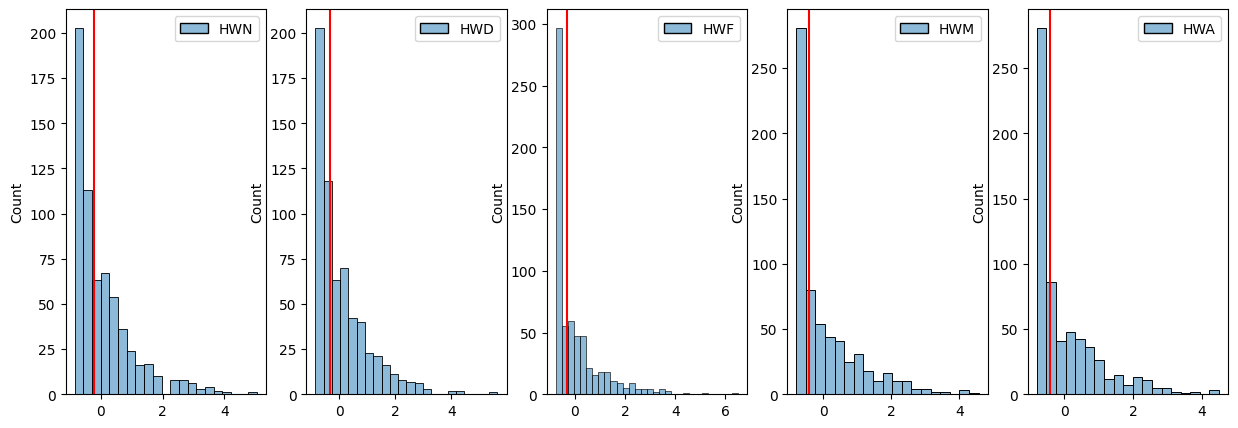

In [8]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])
    axs[i].axvline(np.median(hws[[index]]), color='red')

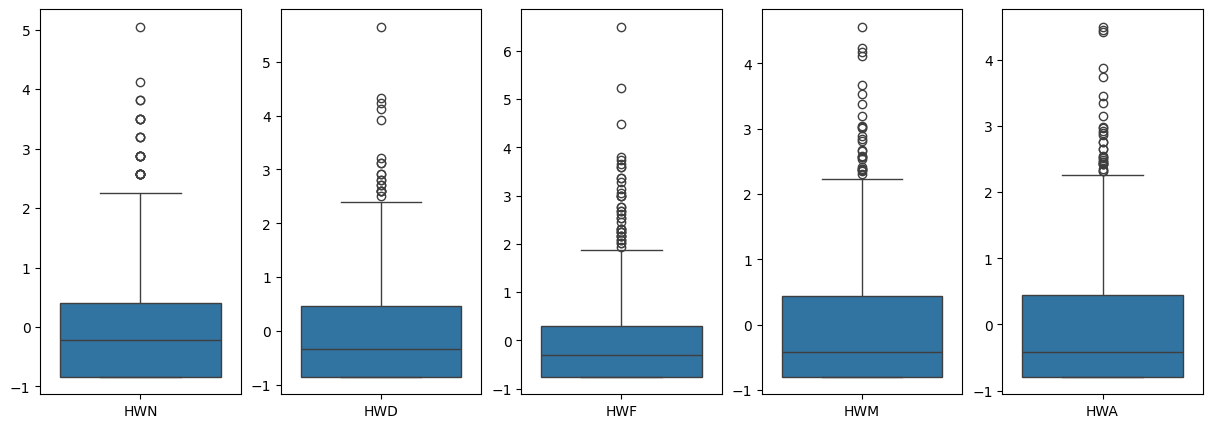

In [9]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.boxplot(hws[[index]], ax=axs[i])

In [10]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])

In [11]:
compute_adjusted_boxplot_bounds(hws_index)

(-1.1692892810242344, -0.30647585455315646, 4.561547586528888)

In [12]:
relevance = create_relevance_function_tukey(hws_index)

Lower, median, upper, max:
[-1.16928928 -0.30647585  4.56154759  6.49996949]


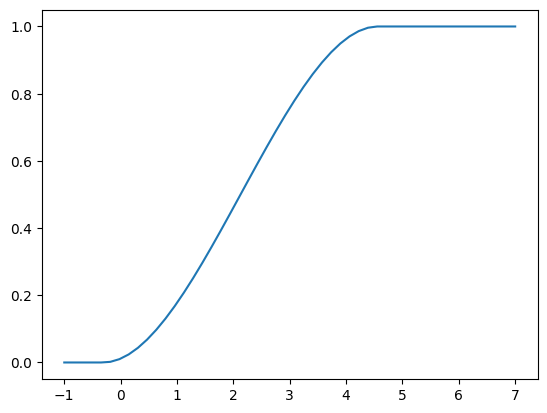

In [13]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))

## Seasonly Relevance Function

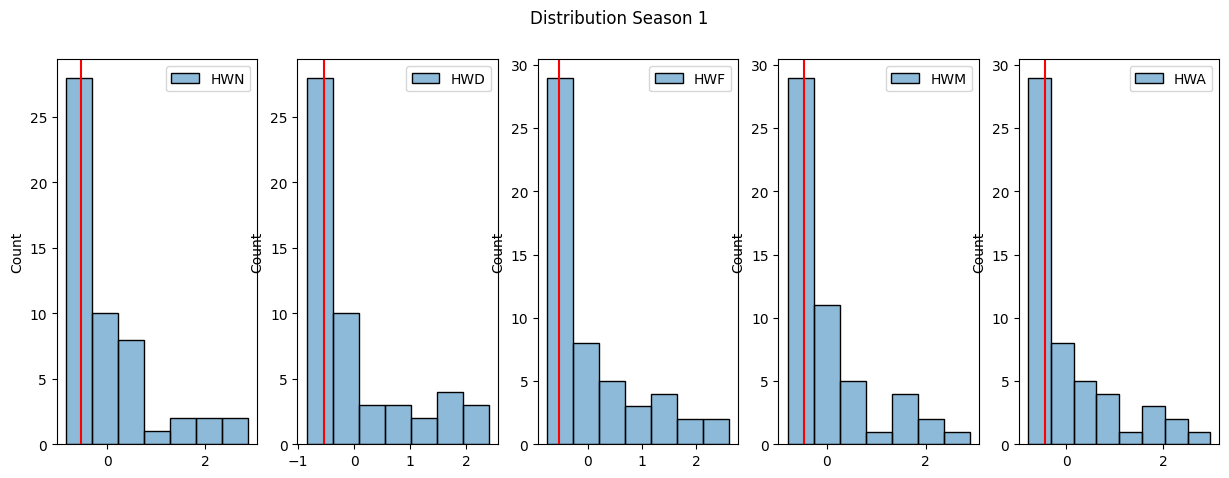

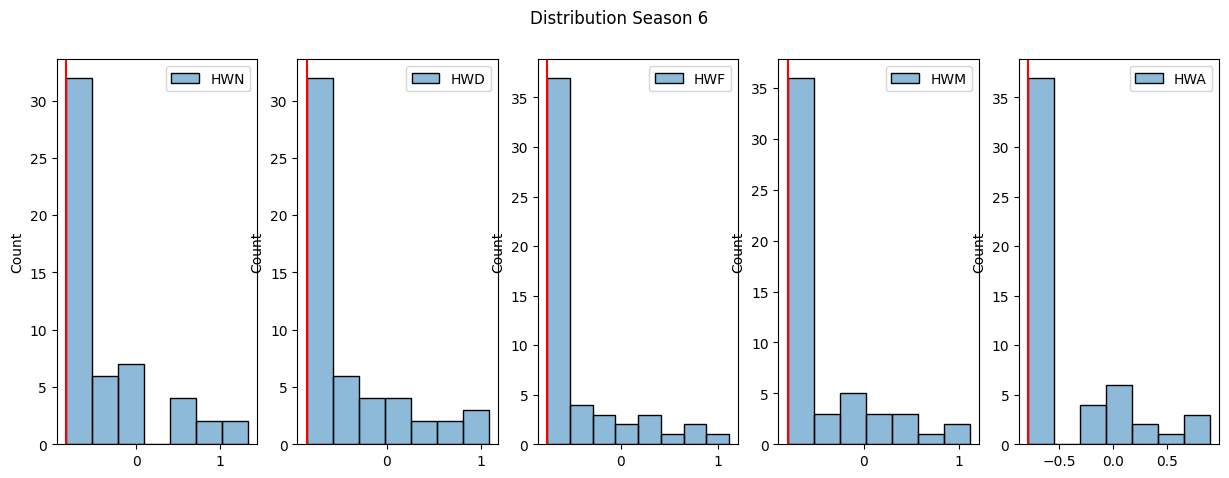

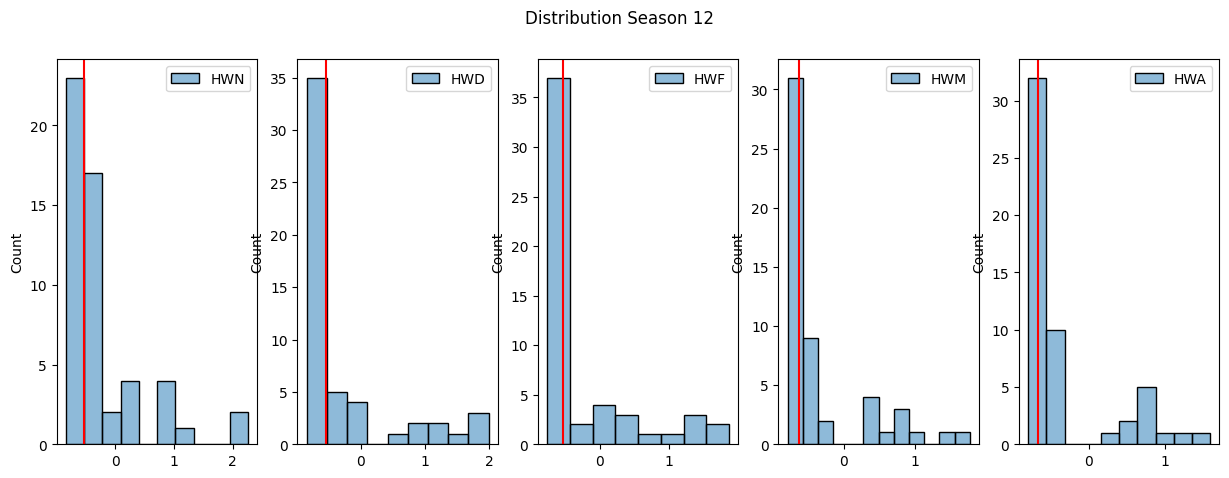

In [14]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
seasons = [1, 6, 12]
for i, season in enumerate(seasons):
    hws_month = hws[hws.index.month==season]
    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    for i, index in enumerate(indices):
        sns.histplot(hws_month[[index]], ax=axs[i])
        axs[i].axvline(np.median(hws_month[[index]]), color='red')
    fig.suptitle(f"Distribution Season {season}")
    plt.show()

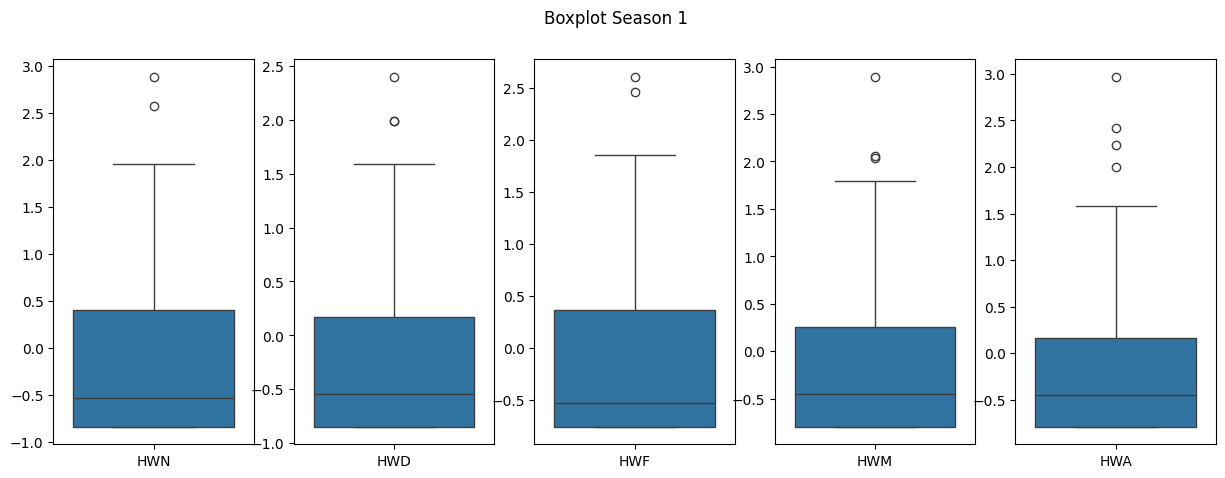

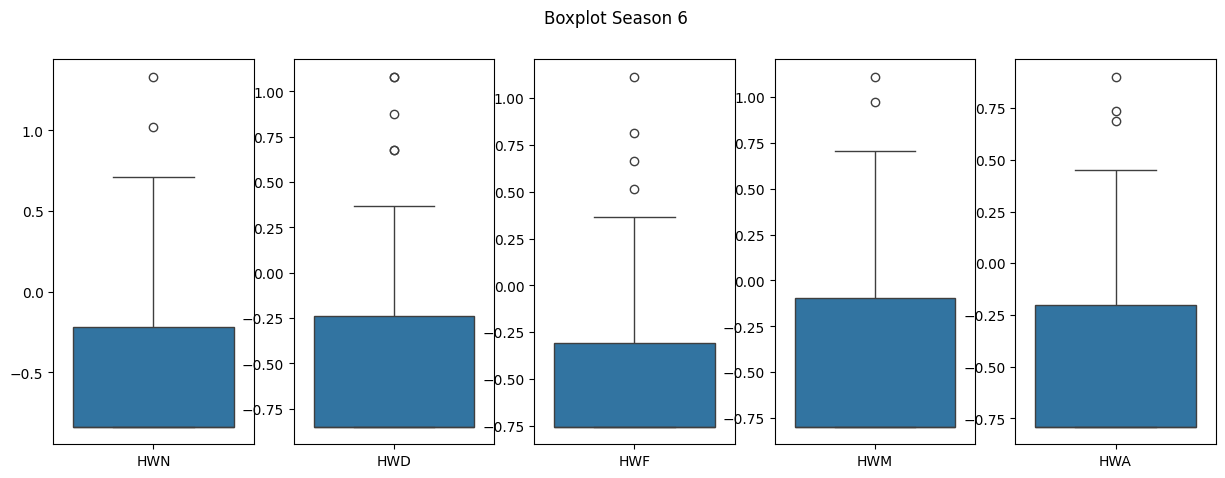

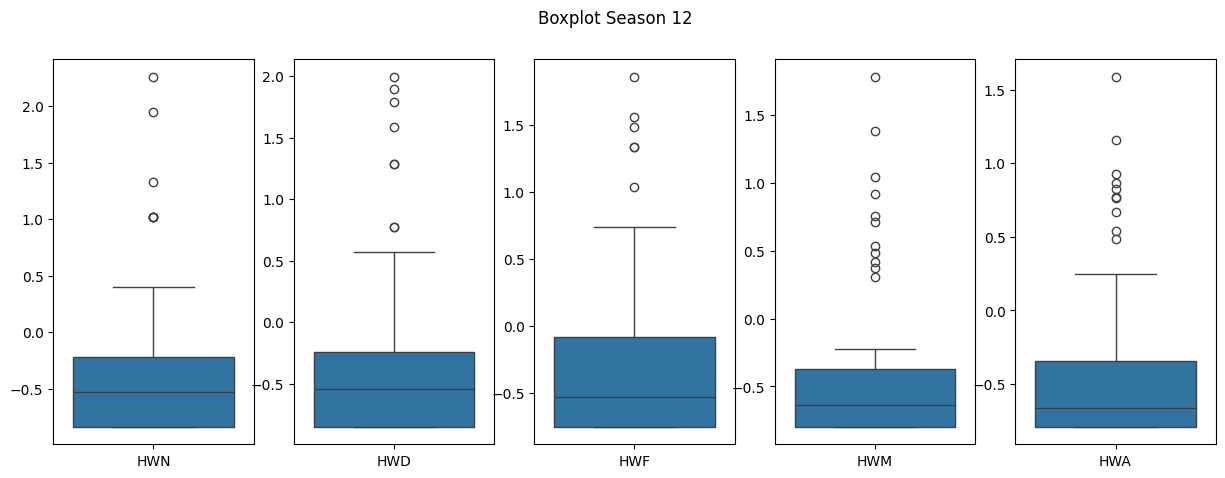

In [15]:
seasons = [1, 6, 12]
for i, season in enumerate(seasons):
    hws_month = hws[hws.index.month==season]
    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    for i, index in enumerate(indices):
        sns.boxplot(hws_month[[index]], ax=axs[i])
    fig.suptitle(f"Boxplot Season {season}")
    plt.show()

In [16]:
relevance_month = {}
for season in seasons:
    hws_month = hws[hws.index.month==season]
    hws_index = hws_month[["HWF"]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    relevance_month[season] = create_relevance_function_tukey(hws_index)

Lower, median, upper, max:
[-0.88172761 -0.53086416 12.09144245  2.61057215]
Lower, median, upper, max:
[-0.76758192 -0.75525247 13.21440308  1.1146501 ]
Lower, median, upper, max:
[-0.89190692 -0.53086416  4.44328628  1.86261112]


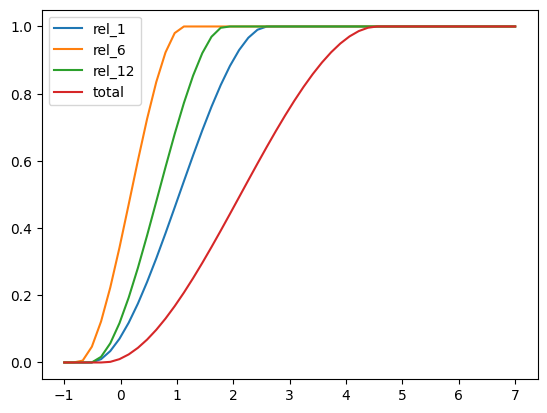

In [17]:
x = np.linspace(-1, 7)
for season in seasons:
    plt.plot(x, relevance_month[season](x), label=f'rel_{season}')
plt.plot(x, relevance(x), label='total')
plt.legend()